In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 5.58 MiB/s, done.
Updating files: 100% (4/4), done.


In [3]:
!ls /content/german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [5]:
np.random.seed(0)

In [6]:
with open("german-traffic-signs/train.p","rb") as f:
    train_data=pickle.load(f)
with open("german-traffic-signs/valid.p","rb") as f:
    val_data=pickle.load(f)
with open("german-traffic-signs/test.p","rb") as f:
    test_data=pickle.load(f)

In [7]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [8]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

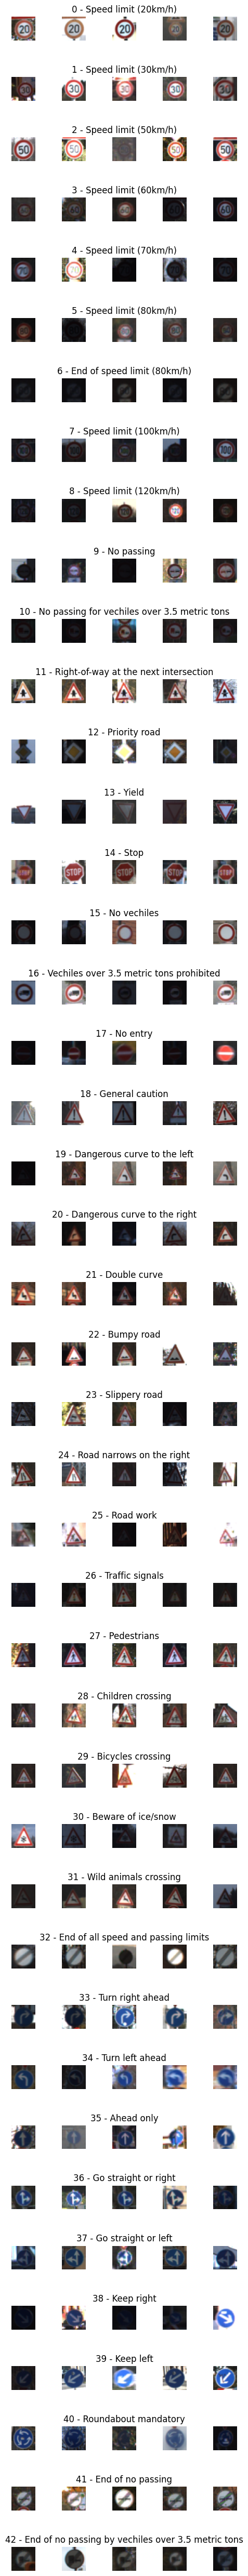

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


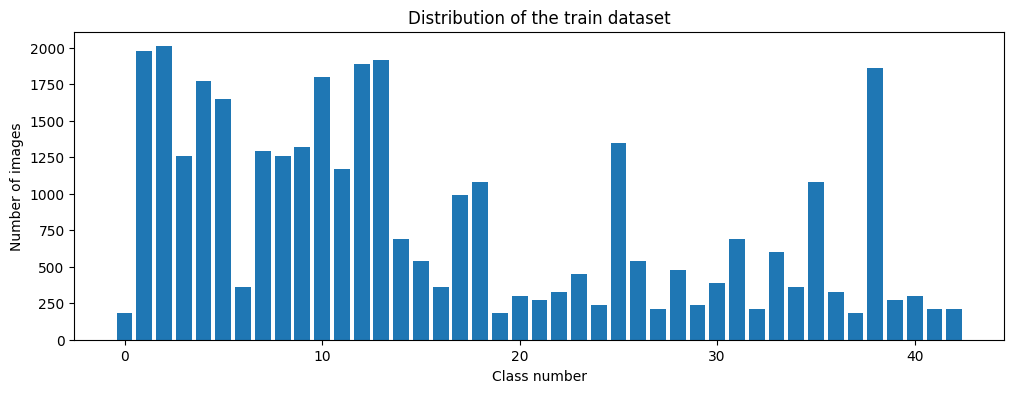

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


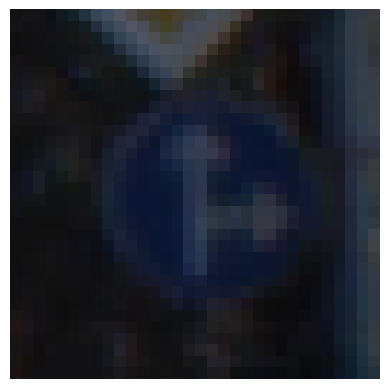

In [11]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


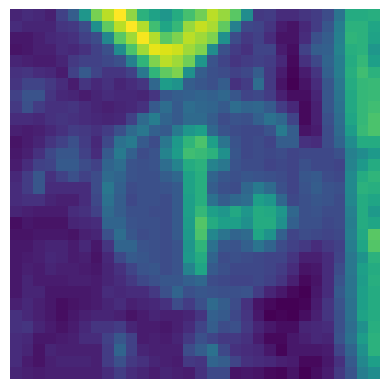

In [12]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


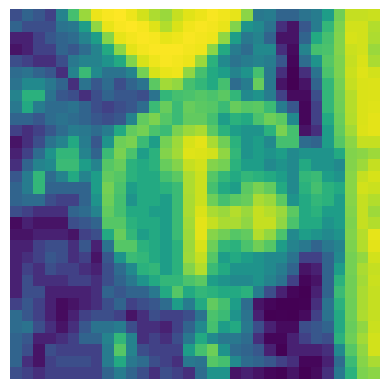

In [13]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [14]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


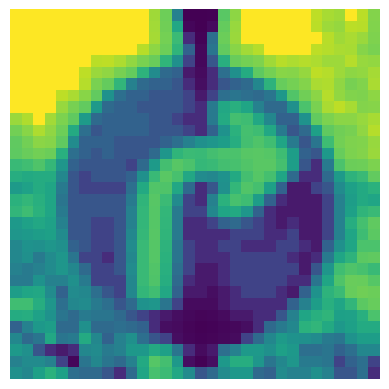

In [15]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(10000, 32, 32, 1)


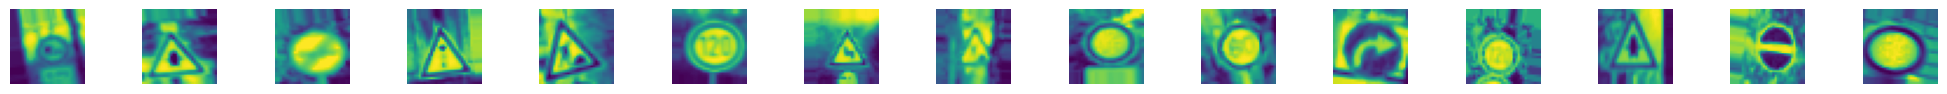

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)
# for X_batch, y_batch in

batches = datagen.flow(X_train, y_train, batch_size = 10000)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
print(X_batch.shape)

In [17]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [18]:
# create model

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [19]:
batch_size = 50
steps_per_epoch = X_train.shape[0] // batch_size

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=steps_per_epoch,
                              epochs=10,
                              validation_data=(X_val, y_val),
                              shuffle=True)

<ipython-input-19-c610f30436dc>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/10
695/695 [==============================] - 25s 27ms/step - loss: 1.7654 - accuracy: 0.5021 - val_loss: 0.2559 - val_accuracy: 0.9336
Epoch 2/10
695/695 [==============================] - 16s 23ms/step - loss: 0.5083 - accuracy: 0.8437 - val_loss: 0.0920 - val_accuracy: 0.9726
Epoch 3/10
695/695 [==============================] - 18s 26ms/step - loss: 0.3134 - accuracy: 0.9029 - val_loss: 0.0786 - val_accuracy: 0.9769
Epoch 4/10
695/695 [==============================] - 16s 23ms/step - loss: 0.2354 - accuracy: 0.9276 - val_loss: 0.0535 - val_accuracy: 0.9848
Epoch 5/10
695/695 [==============================] - 16s 23ms/step - loss: 0.2049 - accuracy: 0.9369 - val_loss: 0.0562 - val_accuracy: 0.9812
Epoch 6/10
695/695 [==============================] - 16s 23ms/step - loss: 0.1794 - accuracy: 0.9451 - val_loss: 0.0485 - val_accuracy: 0.9848
Epoch 7/10
695/695 [==============================] - 17s 24ms/step - loss: 0.1567 - accuracy: 0.9516 - val_loss: 0.0542 - val_accuracy:

Text(0.5, 0, 'epoch')

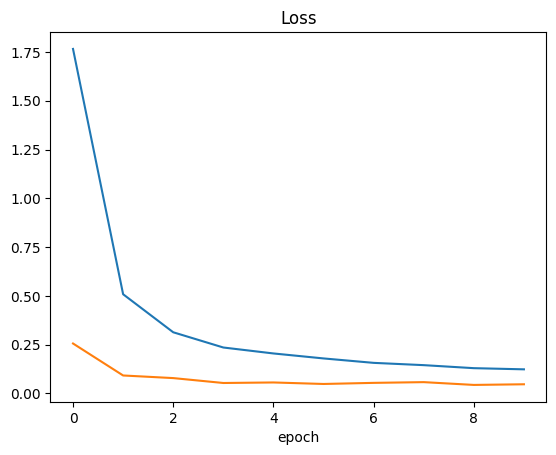

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

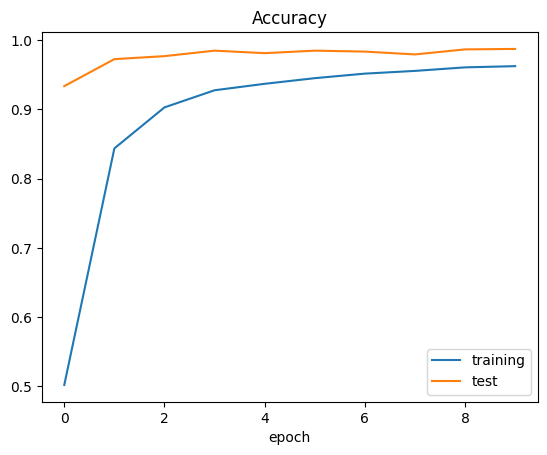

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [22]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.14160580933094025
Test accuracy: 0.9598574638366699


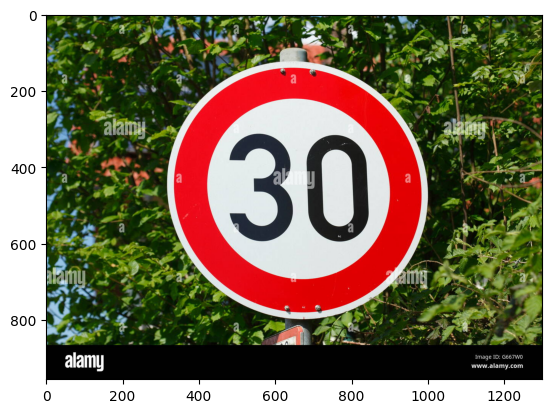

In [23]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


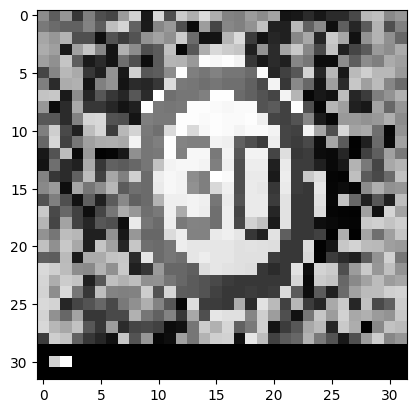

In [24]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [25]:
prediction = model.predict(img).argmax(axis=-1)
#Test image
print("predicted sign: ",data['SignName'][int(prediction)])
print("predicted sign: ",prediction)

1/1 [==============================] - 0s 410ms/step
predicted sign:  Speed limit (30km/h)
predicted sign:  [1]


<ipython-input-25-f64c6f4c0c41>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("predicted sign: ",data['SignName'][int(prediction)])
